## Setup

In [1]:
# # check GPU
!nvidia-smi

Sun Jan 15 13:38:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!rm -rf mode_connectivity
# # pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git


# # checkout specific branch if needed
!cd mode_connectivity

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 1039, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 1039 (delta 115), reused 153 (delta 98), pack-reused 808
Receiving objects: 100% (1039/1039), 38.45 MiB | 38.53 MiB/s, done.
Resolving deltas: 100% (611/611), done.


In [80]:
!touch mode_connectivity/experiments.py

In [10]:
!cd mode_connectivity; git lfs pull -I "model_files/mlp*"
!cd mode_connectivity; git lfs pull -I "model_files/resnet*"

Git LFS: (3 of 3 files) 10.68 MB / 10.68 MB
Git LFS: (9 of 9 files) 65.26 MB / 65.26 MB


In [11]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [13]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.resnet import ResNet
from mode_connectivity.models.vgg import VGG

## Geodesic opt

In [71]:
from utils.utils import get_device
from super import SuperModel
from mode_connectivity.geodesic_opt import optimise_for_geodesic, compare_lmc_to_geodesic, plot_lmc_geodesic_comparison_obj
from mode_connectivity.utils.metrics import JSD_loss, sqrt_JSD_loss, euclid_dist, squared_euclid_dist, index_distance

device, _ = get_device()
path = "mode_connectivity/model_files/"
train_kwargs = {"batch_size": 128, 'num_workers': 0, 'pin_memory': False}
test_kwargs = {"batch_size": 128, 'num_workers': 0, 'pin_memory': False}
train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs, eval_only=True,
)

def load_weights(name, permuted):
    path1 = path + name + "_a.pt"
    path2_end = "_b_permuted.pt" if permuted else "_b.pt"
    path2 = path + name + path2_end
    return torch.load(path1, map_location=device), torch.load(path2, map_location=device)

def get_dataloaders(dataset): # returns a (test, train) pair
    return data.get_data_loaders(
        dataset=dataset, train_kwargs=train_kwargs, test_kwargs=test_kwargs, eval_only=True
    )

In [72]:
# SAMPLE USAGE:
weights_a, weights_b = load_weights("resnet_wm1", True)
mnist_train, mnist_test = get_dataloaders("mnist")

In [73]:
mlp_config = (MLP, "mlp_mnist_model", "", "mnist")
resnet_config = lambda n : (ResNet, "resnet_wm", str(n), "cifar10")
vgg_config = lambda n : (VGG, "vgg_wm", str(n), "cifar10")
# see model_files folder for which numbers are valid

def make_super(config, n, permuted):
    # if permuted=True, uses the permuted version of the weights
    # (it is assumed both permuted and non-permuted exist, this is not a given)
    model_factory, name, name_n, dataset_name = config
    weights_a, weights_b = load_weights(name + name_n, permuted)
    trainloader, testloader = get_dataloaders(dataset_name)
    return SuperModel(config[0], n, weights_a, weights_b).to(device), trainloader, testloader, model_factory

# EXAMPLE USE:
super_mlp = make_super(mlp_config, 20, True)
super_resnet = make_super(resnet_config(1), 20, False)


## HELPER PLOTTING CODE:
def rolling_mean(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

def opt_plot(path_lengths, sq_euc_dists, rolling_mean_length=50):
    fig, ax = plt.subplots()

    rolling_mean_length = rolling_mean(path_lengths, rolling_mean_length)

    loss_type = 'JSD loss'

    ax.plot(rolling_mean_length, color = 'red')
    ax.set_xlabel('GD iteration', fontsize = 14)
    ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

    ax2=ax.twinx()
    ax2.plot(sq_euc_dists, color = 'blue')
    ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)
    fig.show()

Files already downloaded and verified
Files already downloaded and verified


In [74]:
next(iter(get_dataloaders("cifar10")[0]))[0].shape

Files already downloaded and verified
Files already downloaded and verified


torch.Size([128, 3, 32, 32])

### Use these cells to mess with experiments:

In [75]:
# See previous code cell for definition of mlp_config, resnet_config, vgg_config.
# Use these in conjunction with make_super bto easily get the model and train_loader, to use in the next cell.
super_model, train_loader, test_loader, model_factory = make_super(
    resnet_config(1),
    20,
    permuted=True
)

Files already downloaded and verified
Files already downloaded and verified


Optimising geodesic ...
Epoch 0 of 3


100%|██████████| 391/391 [03:24<00:00,  1.91it/s]


epoch 0 | path length 0.9119654674359294 | sq euc dist 222.19620668064908
Epoch 1 of 3


100%|██████████| 391/391 [03:30<00:00,  1.86it/s]


epoch 1 | path length 0.726895832535251 | sq euc dist 224.97228047792868
Epoch 2 of 3


100%|██████████| 391/391 [03:30<00:00,  1.86it/s]


epoch 2 | path length 0.623511981603333 | sq euc dist 225.991834492533


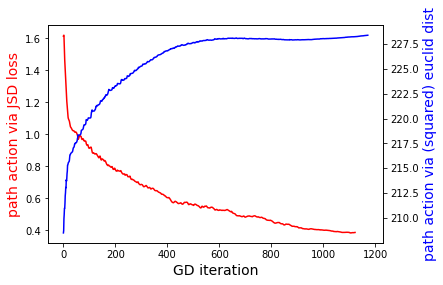

In [77]:
# Run to train; rerun to continue training.
path_lengths, sq_euc_dists  = optimise_for_geodesic(
         super_model,
         train_loader,
         lr = 1e-1,
         verbose=1,
         num_epochs=3)

opt_plot(path_lengths, sq_euc_dists)

Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:10<00:00,  7.24it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:10<00:00,  7.23it/s]


(<Figure size 864x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f1dd42b20>,
       dtype=object))

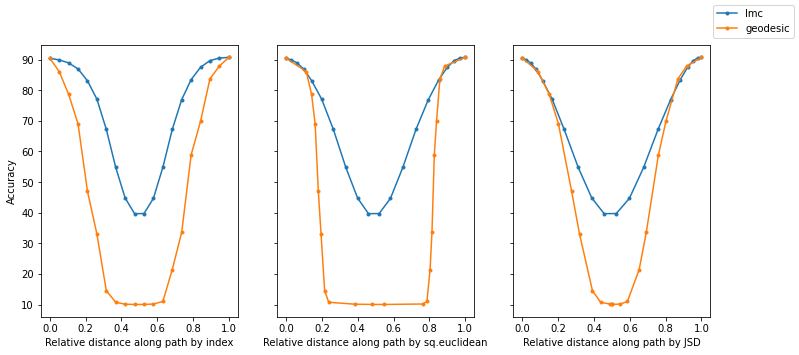

In [78]:
# plot the loss barrier of the trained super_model, compared to LMC:
# comparison = compare_lmc_to_geodesic(
#     super_model,
#     model_factory,
#     test_loader,
#     distance_metric={
#         "index": index_distance,
#         "sq.euclidean": euclid_dist,
#         "JSD": sqrt_JSD_loss
#     },
#     verbose = 1,
# )
# plot_lmc_geodesic_comparison_obj(
#     comparison,
#     figsize=(12, 5),
#     relative_x = True
# )

Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:11<00:00,  7.01it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 391/391 [00:53<00:00,  7.31it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 391/391 [00:53<00:00,  7.28it/s]


(<Figure size 864x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ee307a880>,
       dtype=object))

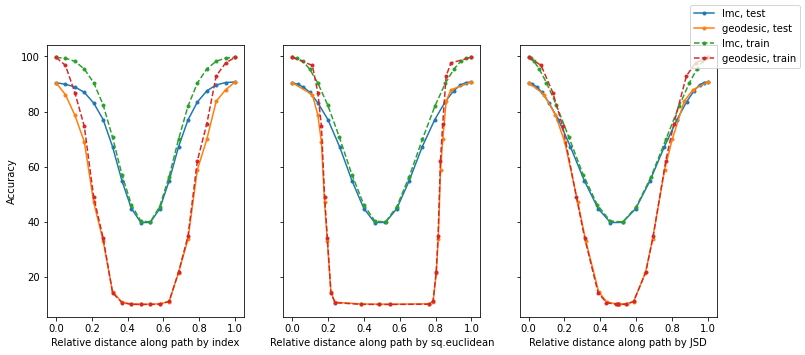

In [79]:
# plot the loss barrier of the trained super_model, compared to LMC:
comparison = compare_lmc_to_geodesic(
    super_model,
    model_factory,
    (test_loader, train_loader),
    distance_metric={
        "index": index_distance,
        "sq.euclidean": euclid_dist,
        "JSD": sqrt_JSD_loss
    },
    verbose = 1,
)
plot_lmc_geodesic_comparison_obj(
    comparison,
    figsize=(12, 5),
    relative_x=True
)

In [81]:
comparison

({'lmc': {'accuracies': array([90.427216, 89.88331 , 88.91416 , 86.93631 , 83.05973 , 77.08663 ,
          67.21717 , 54.786392, 44.808147, 39.71519 , 39.754745, 44.729034,
          54.83584 , 67.19739 , 76.91851 , 83.44541 , 87.480225, 89.65585 ,
          90.49644 , 90.714005], dtype=float32),
   'index': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.]),
   'sq.euclidean': array([17.53316288, 19.33207365, 22.58266017, 27.52664688, 33.72037125,
          39.73906903, 42.39995174, 39.93968603, 36.86333563, 36.32765148,
          38.45045102, 42.05918323, 44.45491163, 41.97824077, 35.67580537,
          28.83937361, 23.48512913, 19.63565436, 17.38714511]),
   'JSD': array([0.07248166, 0.08280629, 0.09896335, 0.1328189 , 0.17812641,
          0.22938883, 0.26841695, 0.2585578 , 0.23471547, 0.23107452,
          0.25036707, 0.27163986, 0.2738633 , 0.23901599, 0.18393284,
          0.13992073, 0.10808875, 0.08378037, 0.0723098 ])},
  'geodesic'

In [84]:
batch = next(iter(test_loader))[0].to(device)
JSD_loss(super_model.models[0](batch), super_model.models[-1](batch))

tensor(0.0854, device='cuda:0')

In [30]:
# TODO: plot contour plot / anything else to be plotted about the trained model:

# EXPERIMENTS.PY TESTS

In [100]:
from mode_connectivity.experiments import mlp_config, resnet_config, run_experiment

Optimising geodesic ...
Epoch 0 of 2


100%|██████████| 469/469 [00:17<00:00, 27.34it/s]


epoch 0 | path length 0.001445527717561475 | sq euc dist 52.00214244460246
Epoch 1 of 2


100%|██████████| 469/469 [00:17<00:00, 26.09it/s]


epoch 1 | path length 0.0013631042322021789 | sq euc dist 52.002553081715796
Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:01<00:00, 65.11it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 79/79 [00:01<00:00, 68.14it/s]


Calculating LMC train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 469/469 [00:06<00:00, 69.34it/s]


Calculating geodesic train accuracies ...
Calculating path length and acc over SuperModel:


100%|██████████| 469/469 [00:06<00:00, 68.58it/s]


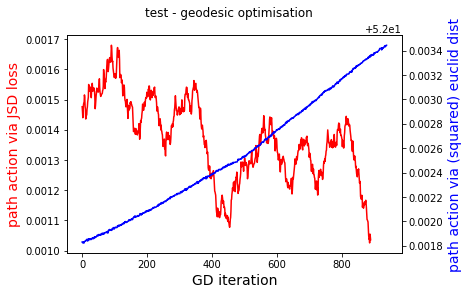

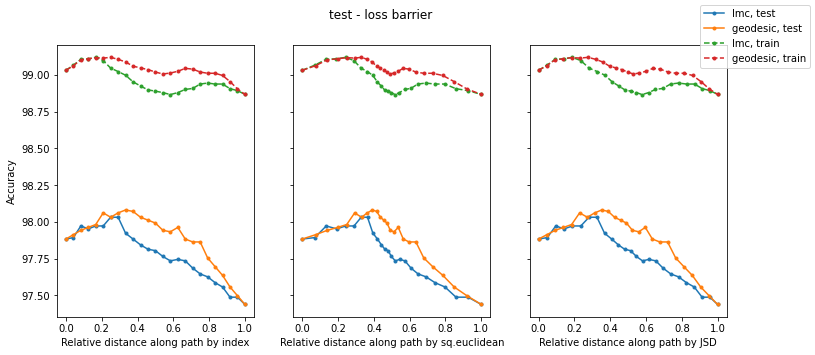

In [101]:
comparison, fig, fig2 = run_experiment(
    mlp_config,
    n_points = 25,
    permute = True,
    geodesic_opt_lr = 1e-1,
    geodesic_opt_epochs = 2,
    plot_figsize=(12,5),
    plot_relative_x=True,
    distance_metrics={
        "index": index_distance,
        "sq.euclidean": euclid_dist,
        "JSD": sqrt_JSD_loss
    },
    save_path = "mode_connectivity/experiments/",
    experiment_name = "test"
)